# Insert USGS 3DEP elevation in SUMMA set up
Inserts elevation of each HRU into the attributes `.nc` file. The intersection code stores this value in field `elev_mean`. 

If the field `settings_summa_connect_HRUs` is set to `yes` in the control file, this script also finds the downslope HRU (attribute `downHRUindex`) for the HRUs within each GRU. The most downstream HRU (i.e. the GRU outlet) is set to `0` to follow SUMMA conventions. If `settings_summa_connect_HRUs` is set to `no`, all HRUs are modelled as indepdendent columns and outflow from all HRUs inside each GRU is combined into basin-average outflow. No further action is needed, as `downHRUindex` for each HRU has already been set to `0`.

In [1]:
# modules
import os
os.chdir('/home/dlhogan/GitHub/mtn_hydro_pysumma')
import numpy as np
import netCDF4 as nc4
import geopandas as gpd
from pathlib import Path
from shutil import copyfile
from datetime import datetime
from utils.read_files import read_from_control, make_default_path

#### Control file handling

In [2]:
# Store the name of the 'active' file in a variable
basin = "EastRiver"
controlFile = f'control_{basin}.txt'

#### Find shapefile location and name

In [3]:
# Path to and name of shapefile with intersection between catchment and soil classes
intersect_path = read_from_control(controlFile,'intersect_dem_path')
intersect_name = read_from_control(controlFile,'intersect_dem_name')

In [4]:
# Specify default path if needed
if intersect_path == 'default':
    intersect_path = make_default_path('shapefiles/catchment_intersection/with_dem', controlFile) # outputs a Path()
else:
    intersect_path = Path(intersect_path) # make sure a user-specified path is a Path()

In [5]:
# Variable names used in shapefile
intersect_hruId_var = read_from_control(controlFile,'catchment_shp_hruid')
intersect_gruId_var = read_from_control(controlFile,'catchment_shp_gruid')

#### Find where the attributes file is

In [6]:
# Attribute path & name
attribute_path = read_from_control(controlFile,'settings_summa_path')
attribute_name = read_from_control(controlFile,'settings_summa_attributes')

In [7]:
# Specify default path if needed
if attribute_path == 'default':
    attribute_path = make_default_path('settings/SUMMA', controlFile) # outputs a Path()
else:
    attribute_path = Path(attribute_path) # make sure a user-specified path is a Path()

#### Open the shapefile

In [40]:
# Open files
shp = gpd.read_file(intersect_path/intersect_name)

#### Define `downHRUindex` values if requested

In [41]:
# Create a field with downHRUindex = 0, that we wil potentially overwrite
shp['downHRUindex'] = 0

# Find if this is requested by the user
do_downHRUindex = read_from_control(controlFile,'settings_summa_connect_HRUs')

In [43]:
# Find the downHRUindex value if requested
if do_downHRUindex.lower() == 'yes':
    
    # Find the unique GRU IDs
    gru_ids = shp[intersect_gruId_var].unique()
    
    # Create a temporary field we'll fill
    shp['downHRUindex'] = 0
    
    # Make hruId the index
    shp.set_index(intersect_hruId_var, inplace=True)
    
    # Loop over the GRUs
    for gru_id in gru_ids:
    
        # Select only the GRU we're currently working on
        gru_mask = (shp[intersect_gruId_var] == gru_id)
    
        # Find the soring order of HRUs in this GRU based on their elevations
        tmp_sort = shp[gru_mask]['elev_mean'].argsort()
    
        # Loop over the HRUs in this GRU and set their downHRUindex in the shapefile
        HRUs_seen = 0
        last_HRU = 0
        for HRU,order in tmp_sort.items():
            if order == 0: 
                # most downstream HRU
                print('Filling downHRUindex of HRU {} with HRU {}'.format(last_HRU,HRU)) 
                print('Filling downHRUindex of HRU {} with HRU {}'.format(HRU,0)) 
                if last_HRU != 0: # If there are more HRUs in this GRU ...
                    shp.at[last_HRU, 'downHRUindex'] = int(HRU) # fill the second-to last and also ...
                shp.at[HRU,      'downHRUindex'] = 0   # fill the last (possibly only) HRU
            elif HRUs_seen > 0:
                # not the first iteration
                print('Filling downHRUindex of HRU {} with HRU {}'.format(last_HRU,HRU))        
                shp.at[last_HRU, 'downHRUindex'] = int(HRU)
            HRUs_seen += 1
            last_HRU = HRU
            
    # Reset the index
    shp.reset_index(inplace=True)

Filling downHRUindex of HRU 0 with HRU 0
Filling downHRUindex of HRU 0 with HRU 0
Filling downHRUindex of HRU 0 with HRU 1
Filling downHRUindex of HRU 1 with HRU 2


#### Open the attributes file and fill the placeholder values in the attributes file

In [44]:
# Open the netcdf file for reading+writing
with nc4.Dataset(attribute_path/attribute_name, "r+") as att:
    
    # Loop over the HRUs in the attributes
    for idx in range(0,len(att['hruId'])):
        
        # Find the HRU ID (attributes file) at this index
        attribute_hru = att['hruId'][idx]
    
        # Find the row in the shapefile that contains info for this HRU
        shp_mask = (shp[intersect_hruId_var].astype(int) == attribute_hru)
        
        # Find the elevation & downHRUindex
        tmp_elev = shp['elev_mean'][shp_mask].values[0]
        tmp_down = shp['downHRUindex'][shp_mask].values[0]
        
        # Replace the value
        print('Replacing elevation {} [m] with {} [m] at HRU {}'.format(att['elevation'][idx],tmp_elev,attribute_hru))
        att['elevation'][idx] = tmp_elev
        
        if do_downHRUindex.lower() == 'yes':
            print('Replacing downHRUindex {} with {} at HRU {}'.format(att['downHRUindex'][idx],tmp_down,attribute_hru))
            att['downHRUindex'][idx] = tmp_down

Replacing elevation -999.0 [m] with 2729.7133772821903 [m] at HRU 0
Replacing downHRUindex 0 with 1 at HRU 0
Replacing elevation -999.0 [m] with 3142.855569209097 [m] at HRU 1
Replacing downHRUindex 0 with 2 at HRU 1
Replacing elevation -999.0 [m] with 3576.049575161355 [m] at HRU 2
Replacing downHRUindex 0 with 0 at HRU 2


## Check
Plot the elevations.

In [45]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

In [46]:
# Open the files 
shp = gpd.read_file(intersect_path/intersect_name)
att = xr.open_dataset(attribute_path/attribute_name)

In [47]:
# Set HRU IDs as index in the shape
shp = shp.set_index(intersect_hruId_var)

In [48]:
# Sort the shape to match the order of the attributes
shp = shp.loc[att['hruId'].values]

In [49]:
# temporarily store the soiltype in the shape for plotting
shp['elevation'] = att['elevation'][:]

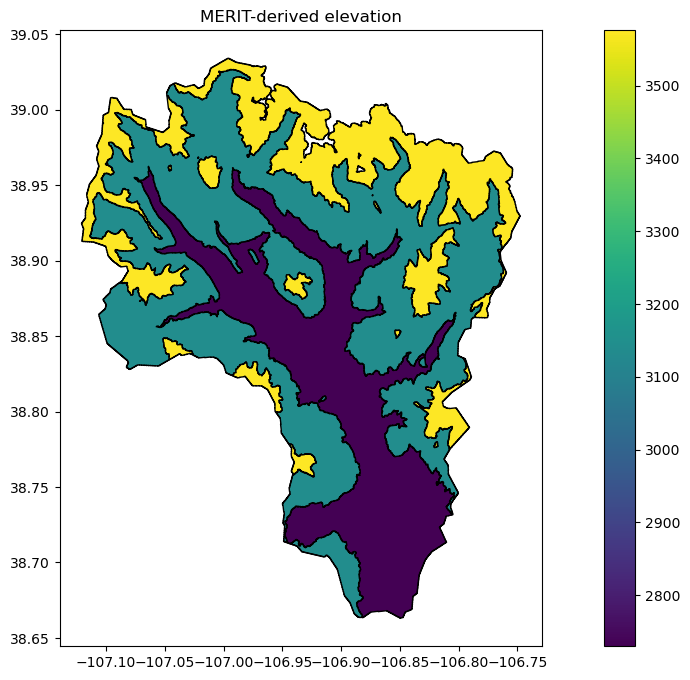

In [50]:
# Make a plot to see what we did
shp.plot(column='elevation',figsize=(16,8), legend=True,edgecolor='k')
ax = plt.gca()
ax.set_title('MERIT-derived elevation');

In [51]:
# Close the netCDF file
att.close()